In [1]:
import torch
import numpy as np
from cka import CKA, CudaCKA

In [2]:

# np_cka = CKA()

# X = np.random.randn(10000, 100)
# Y = np.random.randn(10000, 100)

# print('Linear CKA, between X and Y: {}'.format(np_cka.linear_CKA(X, Y)))
# print('Linear CKA, between X and X: {}'.format(np_cka.linear_CKA(X, X)))

# print('RBF Kernel CKA, between X and Y: {}'.format(np_cka.kernel_CKA(X, Y)))
# print('RBF Kernel CKA, between X and X: {}'.format(np_cka.kernel_CKA(X, X)))

In [3]:
%%time

device = torch.device('cuda:0')
cuda_cka = CudaCKA(device)

X = torch.randn(10000, 100, device=device)
Y = torch.randn(10000, 100, device=device)

print('Linear CKA, between X and Y: {}'.format(cuda_cka.linear_CKA(X, Y)))
print('Linear CKA, between X and X: {}'.format(cuda_cka.linear_CKA(X, X)))

print('RBF Kernel CKA, between X and Y: {}'.format(cuda_cka.kernel_CKA(X, Y)))
print('RBF Kernel CKA, between X and X: {}'.format(cuda_cka.kernel_CKA(X, X)))

Linear CKA, between X and Y: 0.010008406825363636
Linear CKA, between X and X: 1.0
RBF Kernel CKA, between X and Y: 0.01677781343460083
RBF Kernel CKA, between X and X: 1.0
CPU times: user 5.31 s, sys: 3.67 s, total: 8.98 s
Wall time: 8.98 s


# Model

In [4]:
import torch 

m0 = torch.load('results/model_0.pt')
m1 = torch.load('results/model_0.1.pt')
m2 = torch.load('results/model_0.2.pt')
m3 = torch.load('results/model_0.3.pt')
m4 = torch.load('results/model_0.4.pt')

In [5]:
from data import get_cifar10_dataset
trainset, testset, train_loader, valid_loader = get_cifar10_dataset()

features= [] 

for m in [m0,m1,m2, m3, m4]:
    features.append([[],[],[]])
    for i, (x,y) in enumerate(testset):
        if i>=1000:
            break 
        x = x.cuda().unsqueeze(0)
        x += torch.rand_like(x)
        conv1 = m.c1(x)
        conv2 = m.c2(conv1)
        final = m.final(conv2)
        features[-1][0].append(conv1.flatten().clone().detach())
        features[-1][1].append(conv2.flatten().clone().detach())
        features[-1][2].append(final.flatten().clone().detach())


Files already downloaded and verified
Files already downloaded and verified
[+] Finished loading data & Preprocessing


In [6]:

device = torch.device('cuda:0')
cuda_cka = CudaCKA(device)

linear = [] 
rbf = []

dic = {
    'target': [],
    'layer' : [],
    'kernel' : [],
    'sim' : [] 
}
import pandas as pd 

for layer in range(3):
    f0 = torch.stack(features[0][layer])
    for eps in range(4):
        f_target = torch.stack(features[eps+1][layer])
        X= f0
        Y= f_target
        # Linear
        dic['target'].append(eps)
        dic['layer'].append(layer)
        dic['kernel'].append("linear")
        dic['sim'].append(cuda_cka.linear_CKA(X, Y).item())
        
        # RBF
        dic['target'].append(eps)
        dic['layer'].append(layer)
        dic['kernel'].append("rbf")
        dic['sim'].append(cuda_cka.kernel_CKA(X, Y).item())
        
df = pd.DataFrame(dic)

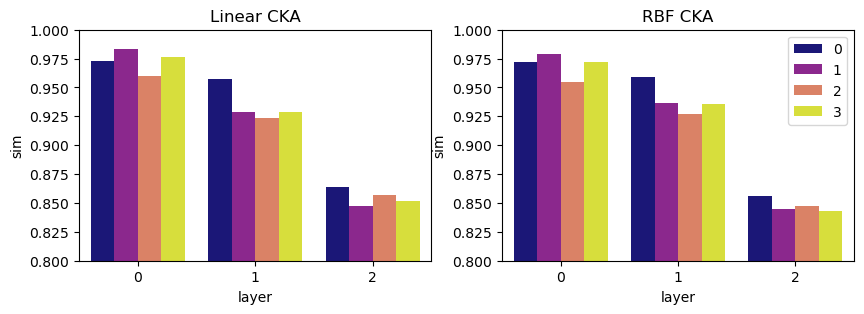

In [29]:
import seaborn as sns 
import matplotlib.cm as cm 
import matplotlib.pyplot as plt 

fig, axes = plt.subplots(1,2, figsize=(10,3))
cmap = cm.get_cmap("plasma")
temp = df[df['kernel']=='linear']
sns.barplot(x='layer', y='sim', data=temp, hue='target', palette=[cmap(i/3) for i in range(4)], ax=axes[0])
axes[0].set_title("Linear CKA")
axes[0].get_legend().remove()
axes[0].set_ylim((0.8, 1.0))


temp = df[df['kernel']=='rbf']
sns.barplot(x='layer', y='sim', data=temp, hue='target', palette=[cmap(i/3) for i in range(4)], ax=axes[1])
axes[1].set_title("RBF CKA")
axes[1].legend(bbox_to_anchor=(1,1))
axes[1].set_ylim((0.8, 1.0))
plt.savefig("results/cka.pdf")


In [8]:
df

,target,layer,kernel,sim
0,0,0,linear,0.972732
1,0,0,rbf,0.972091
2,1,0,linear,0.982938
3,1,0,rbf,0.979212
4,2,0,linear,0.960121
5,2,0,rbf,0.955050
6,3,0,linear,0.976062
7,3,0,rbf,0.972129
8,0,1,linear,0.957470
9,0,1,rbf,0.958859


In [16]:
from tqdm import tqdm 
performs = [] 
for m in [m0,m1,m2, m3, m4]:
    eq = 0
    for (x, y) in tqdm((valid_loader)):
        x = x.to("cuda:0")
        y = y.to("cuda:0")
        y_hat = m(x).argmax(dim=-1)
        eq += (y == y_hat).sum()

    current_performance = eq/len(testset)
    print(current_performance)
    performs.append(current_performance.item())
    

100%|██████████| 157/157 [00:02<00:00, 62.09it/s]


tensor(0.6524, device='cuda:0')


100%|██████████| 157/157 [00:02<00:00, 65.04it/s]


tensor(0.6531, device='cuda:0')


100%|██████████| 157/157 [00:02<00:00, 64.65it/s]


tensor(0.6529, device='cuda:0')


100%|██████████| 157/157 [00:02<00:00, 63.02it/s]


tensor(0.6458, device='cuda:0')


100%|██████████| 157/157 [00:02<00:00, 64.08it/s]

tensor(0.6330, device='cuda:0')


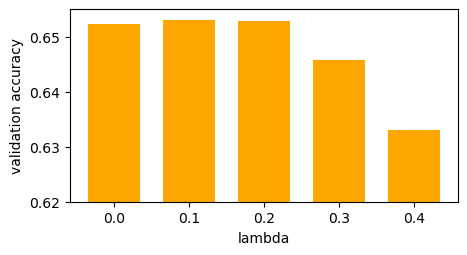

In [38]:
plt.figure(figsize=(5, 2.5))
plt.bar(x=[0.1*i for i in range(5)], height=performs, width=0.07, color='orange')
plt.ylim(0.62, 0.655)
plt.xlabel("lambda")
plt.ylabel("validation accuracy")
plt.savefig("results/acc.pdf")
